# Student Performance Prediction (Classification)

**Dataset:** `StudentsPerformance.csv`  
**Source:** [Kaggle - Students Performance in Exams](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams)  

## Project Idea

This project predicts student academic performance based on demographic and socioeconomic features using Apache Spark for scalable machine learning.

#### The data contains:

**Demographic features:** gender, race/ethnicity

**Socioeconomic features:** parental level of education, lunch type

**Academic preparation:** test preparation course

**Target scores:** math score, reading score, writing score

## Goal

Predict whether a student will have High, Medium, or Low performance based on their average test score.

Help educators identify students who may need additional support.

Use Spark ML for scalability and efficient handling of large datasets.

## Phase 0: Import libraries & Load Data

In [1]:
#  Create Spark Session
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder \
    .appName("Student Performance - Data Understanding") \
    .getOrCreate()

print("Spark Session Created Successfully")


Spark Session Created Successfully


In [2]:
df = spark.read.csv(
    "../data/raw/StudentsPerformance.csv",
    header=True,
    inferSchema=True
)

print("Dataset loaded")
print(f"Shape: {df.count()} rows, {len(df.columns)} columns")

Dataset loaded
Shape: 1000 rows, 8 columns


## Phase 1: Data Understanding

In [3]:
# Dataset Shape
rows = df.count()
cols = len(df.columns)

print(f"Dataset Shape: {rows} rows, {cols} columns")

Dataset Shape: 1000 rows, 8 columns


In [4]:
# Preview Dataset
print("First 5 rows:")
df.show(5, truncate=False)

print("\nRandom sample:")
df.sample(fraction=0.01, seed=42).show(5, truncate=False)

First 5 rows:
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch       |test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|group B       |bachelor's degree          |standard    |none                   |72        |72           |74           |
|female|group C       |some college               |standard    |completed              |69        |90           |88           |
|female|group B       |master's degree            |standard    |none                   |90        |95           |93           |
|male  |group A       |associate's degree         |free/reduced|none                   |47        |57           |44           |
|male  |group C       |some college               |standard    |none                   |76

In [5]:
# Dataset Schema & Info
print("Dataset Schema:")
df.printSchema()

Dataset Schema:
root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)



#### Identify Columns Types

In [6]:
# Identify numerical & categorical columns
numerical_cols = ['math score', 'reading score', 'writing score']
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['math score', 'reading score', 'writing score']
Categorical Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


In [7]:
# Unique Values per Column
print("Unique values per column:")
for col_name in df.columns:
    print(f"{col_name}: {df.select(col_name).distinct().count()}")

Unique values per column:
gender: 2
race/ethnicity: 5
parental level of education: 6
lunch: 2
test preparation course: 2
math score: 81
reading score: 72
writing score: 77


In [8]:
# Score statistics
print("Score statistics:")
df.select(
    F.min("math score").alias("Min Math"),
    F.max("math score").alias("Max Math"),
    F.avg("math score").alias("Avg Math"),
    F.min("reading score").alias("Min Reading"),
    F.max("reading score").alias("Max Reading"),
    F.avg("reading score").alias("Avg Reading"),
    F.min("writing score").alias("Min Writing"),
    F.max("writing score").alias("Max Writing"),
    F.avg("writing score").alias("Avg Writing")
).show()

Score statistics:
+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+
|Min Math|Max Math|Avg Math|Min Reading|Max Reading|Avg Reading|Min Writing|Max Writing|Avg Writing|
+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+
|       0|     100|  66.089|         17|        100|     69.169|         10|        100|     68.054|
+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+



In [9]:
# Score distributions
print("Math score distribution (binned):")
df.withColumn("math_bin", 
    F.when(F.col("math score") >= 90, "90-100")
     .when(F.col("math score") >= 80, "80-89")
     .when(F.col("math score") >= 70, "70-79")
     .when(F.col("math score") >= 60, "60-69")
     .otherwise("Below 60")
).groupBy("math_bin").count().orderBy("math_bin").show()

Math score distribution (binned):
+--------+-----+
|math_bin|count|
+--------+-----+
|   60-69|  268|
|   70-79|  216|
|   80-89|  135|
|  90-100|   58|
|Below 60|  323|
+--------+-----+



In [10]:
# Range Validation for Score Features
print("Range check for score features:")
for score_col in numerical_cols:
    min_val = df.agg(F.min(score_col)).collect()[0][0]
    max_val = df.agg(F.max(score_col)).collect()[0][0]
    print(f"{score_col}: min={min_val}, max={max_val}")

Range check for score features:
math score: min=0, max=100
reading score: min=17, max=100
writing score: min=10, max=100


In [11]:
# No high-cardinality identifiers in this dataset
# All columns are meaningful features
print("Column value counts:")
for col_name in df.columns:
    unique_count = df.select(col_name).distinct().count()
    print(f"{col_name}: {unique_count} unique values")

Column value counts:
gender: 2 unique values
race/ethnicity: 5 unique values
parental level of education: 6 unique values
lunch: 2 unique values
test preparation course: 2 unique values
math score: 81 unique values
reading score: 72 unique values
writing score: 77 unique values


In [12]:
# Categorical Feature Distributions
for col_name in categorical_cols:
    print(f"\nDistribution of {col_name}:")
    df.groupBy(col_name).count().orderBy(F.desc("count")).show()


Distribution of gender:
+------+-----+
|gender|count|
+------+-----+
|female|  518|
|  male|  482|
+------+-----+


Distribution of race/ethnicity:
+--------------+-----+
|race/ethnicity|count|
+--------------+-----+
|       group C|  319|
|       group D|  262|
|       group B|  190|
|       group E|  140|
|       group A|   89|
+--------------+-----+


Distribution of parental level of education:
+---------------------------+-----+
|parental level of education|count|
+---------------------------+-----+
|               some college|  226|
|         associate's degree|  222|
|                high school|  196|
|           some high school|  179|
|          bachelor's degree|  118|
|            master's degree|   59|
+---------------------------+-----+


Distribution of lunch:
+------------+-----+
|       lunch|count|
+------------+-----+
|    standard|  645|
|free/reduced|  355|
+------------+-----+


Distribution of test preparation course:
+-----------------------+-----+
|test prepa

## Phase 2: Data Cleaning

### Handle Missing Values


In [13]:
# Check for missing values first
print("Missing values per column:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Numerical columns -> fill with median (if any nulls)
for col_name in numerical_cols:
    null_count = df.filter(F.col(col_name).isNull()).count()
    if null_count > 0:
        median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]
        df = df.fillna({col_name: median_value})
        print(f"Filled {null_count} nulls in {col_name} with median {median_value}")

# Categorical columns -> fill with mode (if any nulls)
for col_name in categorical_cols:
    null_count = df.filter(F.col(col_name).isNull()).count()
    if null_count > 0:
        mode_row = df.groupBy(col_name).count().orderBy(F.desc("count")).first()
        if mode_row is not None and mode_row[0] is not None:
            mode_value = str(mode_row[0])
            df = df.fillna({col_name: mode_value})
            print(f"Filled {null_count} nulls in {col_name} with mode '{mode_value}'")

print("\nMissing values handled (dataset has no nulls)")

Missing values per column:
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|     0|             0|                          0|    0|                      0|         0|            0|            0|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+


Missing values handled (dataset has no nulls)


In [14]:
# Check Duplicates
duplicates_count = df.count() - df.dropDuplicates().count()
print(f" Number of duplicate rows: {duplicates_count}")

# Remove Duplicates
df = df.dropDuplicates()
print("✅ Duplicate rows removed")
print(" New Dataset Shape:", df.count(), "rows")

 Number of duplicate rows: 0
✅ Duplicate rows removed
 New Dataset Shape: 1000 rows


In [15]:
# For score columns (0-100 range), we don't apply IQR capping
# as all values are valid test scores within the expected range
# Just verify the ranges are correct

print("Score range verification:")
for col_name in numerical_cols:
    min_val = df.agg(F.min(col_name)).collect()[0][0]
    max_val = df.agg(F.max(col_name)).collect()[0][0]
    if min_val >= 0 and max_val <= 100:
        print(f"{col_name}: Valid range [{min_val}, {max_val}]")
    else:
        print(f"{col_name}: WARNING - outside 0-100 range!")

print("\nNo outlier capping needed - scores are within valid 0-100 range")

Score range verification:
math score: Valid range [0, 100]
reading score: Valid range [17, 100]
writing score: Valid range [10, 100]

No outlier capping needed - scores are within valid 0-100 range


## Phase 3: Feature Engineering (Target)

In [16]:
# Create average score from all three test scores
df = df.withColumn(
    "average_score",
    (F.col("math score") + F.col("reading score") + F.col("writing score")) / 3
)

# Create target variable for classification based on average score
df = df.withColumn(
    "PerformanceLevel",
    F.when(F.col("average_score") >= 80, "High")
     .when(F.col("average_score") >= 60, "Medium")
     .otherwise("Low")
)

print("Target variable (PerformanceLevel) created based on average score")
print("\nPerformance Level Distribution:")
df.groupBy("PerformanceLevel").count().orderBy("PerformanceLevel").show()

print("Average score statistics per level:")
df.groupBy("PerformanceLevel").agg(
    F.min("average_score").alias("Min"),
    F.max("average_score").alias("Max"),
    F.avg("average_score").alias("Mean")
).orderBy("PerformanceLevel").show()

Target variable (PerformanceLevel) created based on average score

Performance Level Distribution:
+----------------+-----+
|PerformanceLevel|count|
+----------------+-----+
|            High|  198|
|             Low|  285|
|          Medium|  517|
+----------------+-----+

Average score statistics per level:
+----------------+----+------------------+------------------+
|PerformanceLevel| Min|               Max|              Mean|
+----------------+----+------------------+------------------+
|            High|80.0|             100.0| 87.06397306397307|
|             Low| 9.0|59.666666666666664|50.328654970760226|
|          Medium|60.0| 79.66666666666667| 69.99677627337196|
+----------------+----+------------------+------------------+



In [17]:
# Prepare ML-ready dataset
# Keep all features - no identifiers to drop in this dataset
df_ml = df

print(f"ML-ready dataset prepared: {df_ml.count()} rows, {len(df_ml.columns)} columns")
print("\nFinal columns:")
for col_name in df_ml.columns:
    print(f"  - {col_name}")

ML-ready dataset prepared: 1000 rows, 10 columns

Final columns:
  - gender
  - race/ethnicity
  - parental level of education
  - lunch
  - test preparation course
  - math score
  - reading score
  - writing score
  - average_score
  - PerformanceLevel


### Validate Cleaned Dataset

In [18]:
# Missing values check
print("Missing values check:")
df_ml.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_ml.columns]).show()

# Score range check
print("Score ranges:")
for col_name in numerical_cols:
    min_val = df_ml.agg(F.min(F.col(col_name))).collect()[0][0]
    max_val = df_ml.agg(F.max(F.col(col_name))).collect()[0][0]
    print(f"  {col_name}: [{min_val}, {max_val}]")

# Shape check
print(f"\nCleaned ML-ready Dataset Shape: {df_ml.count()} rows, {len(df_ml.columns)} columns")

Missing values check:
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+-------------+----------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|average_score|PerformanceLevel|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+-------------+----------------+
|     0|             0|                          0|    0|                      0|         0|            0|            0|            0|               0|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+-------------+----------------+

Score ranges:
  math score: [0, 100]
  reading score: [17, 100]
  writing score: [10, 100]

Cleaned ML-ready Dataset Shape: 1000 rows, 10 columns


## Phase 4: Save Cleaned Data

In [19]:
df_ml.toPandas().to_csv(
    r"../data/cleaned/student_performance_cleaned.csv",
    index=False
)

print("✅ Cleaned dataset saved successfully")


✅ Cleaned dataset saved successfully


## Phase 5: Statistical Analysis & Data Summaries



In [20]:
# Select score columns for summary statistics
score_cols = numerical_cols + ['average_score']

# Summary statistics
print("Summary statistics for score columns:")
df.select(score_cols).describe().show()

Summary statistics for score columns:
+-------+------------------+-----------------+------------------+------------------+
|summary|        math score|    reading score|     writing score|     average_score|
+-------+------------------+-----------------+------------------+------------------+
|  count|              1000|             1000|              1000|              1000|
|   mean|            66.089|           69.169|            68.054| 67.77066666666673|
| stddev|15.163080096009455|14.60019193725221|15.195657010869656|14.257325984669148|
|    min|                 0|               17|                10|               9.0|
|    max|               100|              100|               100|             100.0|
+-------+------------------+-----------------+------------------+------------------+



### Categorical Feature Distributions

In [21]:
# Frequency counts for categorical features
for col_name in categorical_cols:
    print(f"\nDistribution of {col_name}:")
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()


Distribution of gender:
+------+-----+
|gender|count|
+------+-----+
|female|  518|
|  male|  482|
+------+-----+


Distribution of race/ethnicity:
+--------------+-----+
|race/ethnicity|count|
+--------------+-----+
|       group C|  319|
|       group D|  262|
|       group B|  190|
|       group E|  140|
|       group A|   89|
+--------------+-----+


Distribution of parental level of education:
+---------------------------+-----+
|parental level of education|count|
+---------------------------+-----+
|               some college|  226|
|         associate's degree|  222|
|                high school|  196|
|           some high school|  179|
|          bachelor's degree|  118|
|            master's degree|   59|
+---------------------------+-----+


Distribution of lunch:
+------------+-----+
|       lunch|count|
+------------+-----+
|    standard|  645|
|free/reduced|  355|
+------------+-----+


Distribution of test preparation course:
+-----------------------+-----+
|test prepa

In [22]:
import numpy as np

def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    return (mean1 - mean2) / pooled_std

print("Cohen's d effect size (High vs Low performance):")
for col_name in score_cols:
    high = df.filter(df["PerformanceLevel"] == "High").select(col_name).toPandas()[col_name]
    low = df.filter(df["PerformanceLevel"] == "Low").select(col_name).toPandas()[col_name]
    
    if len(high) > 1 and len(low) > 1:
        d = cohens_d(high, low)
        effect = "large" if abs(d) > 0.8 else "medium" if abs(d) > 0.5 else "small"
        print(f"  {col_name}: {d:.3f} ({effect} effect)")

Cohen's d effect size (High vs Low performance):
  math score: 3.985 (large effect)
  reading score: 4.898 (large effect)
  writing score: 4.737 (large effect)
  average_score: 5.374 (large effect)


### Correlation Analysis

In [23]:
# Convert score features to Pandas for correlation analysis
corr_matrix = df.select(score_cols).toPandas().corr()

print("Correlation matrix for score columns:")
print(corr_matrix.round(2))

Correlation matrix for score columns:
               math score  reading score  writing score  average_score
math score           1.00           0.82           0.80           0.92
reading score        0.82           1.00           0.95           0.97
writing score        0.80           0.95           1.00           0.97
average_score        0.92           0.97           0.97           1.00


### Multicollinearity Assessment

In [24]:
# Check for high correlations (multicollinearity)
high_corr_pairs = []

for i in range(len(score_cols)):
    for j in range(i + 1, len(score_cols)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append(
                (score_cols[i], score_cols[j], round(corr_value, 2))
            )

print("Highly correlated pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"  {pair[0]} <-> {pair[1]}: r = {pair[2]}")

if not high_corr_pairs:
    print("  None found")

Highly correlated pairs (|r| > 0.8):
  math score <-> reading score: r = 0.82
  math score <-> writing score: r = 0.8
  math score <-> average_score: r = 0.92
  reading score <-> writing score: r = 0.95
  reading score <-> average_score: r = 0.97
  writing score <-> average_score: r = 0.97


### Features Ranking

In [25]:
from pyspark.sql.functions import avg

# Feature means by performance level
print("Average scores by Performance Level:")
feature_means = df.groupBy("PerformanceLevel").agg(
    *[avg(c).alias(c) for c in score_cols]
)
feature_means.show(truncate=False)

Average scores by Performance Level:
+----------------+-----------------+-----------------+-----------------+------------------+
|PerformanceLevel|math score       |reading score    |writing score    |average_score     |
+----------------+-----------------+-----------------+-----------------+------------------+
|High            |85.13636363636364|88.38383838383838|87.67171717171718|87.06397306397307 |
|Low             |49.24912280701754|51.84561403508772|49.89122807017544|50.328654970760226|
|Medium          |68.07736943907156|71.35976789168278|70.55319148936171|69.99677627337196 |
+----------------+-----------------+-----------------+-----------------+------------------+



In [26]:
# Performance level distribution
print("Performance Level Distribution:")
df.groupBy("PerformanceLevel").count().orderBy("PerformanceLevel").show()

Performance Level Distribution:
+----------------+-----+
|PerformanceLevel|count|
+----------------+-----+
|            High|  198|
|             Low|  285|
|          Medium|  517|
+----------------+-----+



### Summary Tables


In [27]:
from pyspark.sql.functions import countDistinct

# Number of unique categories per categorical feature
print("Unique values per categorical feature:")
categorical_summary = df.select([
    countDistinct(c).alias(c) for c in categorical_cols
])
categorical_summary.show()

Unique values per categorical feature:
+------+--------------+---------------------------+-----+-----------------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|
+------+--------------+---------------------------+-----+-----------------------+
|     2|             5|                          6|    2|                      2|
+------+--------------+---------------------------+-----+-----------------------+



## Phase 6: Preprocessing and ML Modeling

In [28]:
# Additional imports for ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

# Use the cleaned dataframe directly (already in memory)
data = df_ml

print("Dataset ready for ML")
print(f"Shape: {data.count()} rows, {len(data.columns)} columns")
data.printSchema()

Dataset ready for ML
Shape: 1000 rows, 10 columns
root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)
 |-- average_score: double (nullable = true)
 |-- PerformanceLevel: string (nullable = false)



In [29]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

print("Train size:", train_df.count())
print("Test size:", test_df.count())

Train size: 838
Test size: 162


In [30]:
label_indexer = StringIndexer(inputCol='PerformanceLevel',outputCol='label').fit(train_df)

train_df = label_indexer.transform(train_df)
test_df = label_indexer.transform(test_df)

In [31]:
# Define categorical columns for encoding
ml_categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Create indexers and encoders for categorical features
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid='keep') for c in ml_categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe") for c in ml_categorical_cols]

print("Categorical feature encoders created for:", ml_categorical_cols)

Categorical feature encoders created for: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


In [32]:
# Define numeric columns for the ML model
# Using the three test scores as features
ml_numeric_cols = ['math score', 'reading score', 'writing score']

numeric_assembler = VectorAssembler(inputCols=ml_numeric_cols, outputCol='numeric_features')
scaler = StandardScaler(inputCol='numeric_features', outputCol='scaled_numeric_features')

print("Numeric feature assembler created for:", ml_numeric_cols)

Numeric feature assembler created for: ['math score', 'reading score', 'writing score']


In [33]:
# Combine all features into final feature vector
feature_cols = ['scaled_numeric_features'] + [f"{c}_ohe" for c in ml_categorical_cols]

final_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

print("Final feature assembler combines:", feature_cols)

Final feature assembler combines: ['scaled_numeric_features', 'gender_ohe', 'race/ethnicity_ohe', 'parental level of education_ohe', 'lunch_ohe', 'test preparation course_ohe']


In [34]:
log_reg = LogisticRegression(
featuresCol='features',
labelCol='label'
)

rand_forest = RandomForestClassifier(
featuresCol='features',
labelCol='label',
seed=42
)

In [35]:
lr_param_grid = (ParamGridBuilder()
.addGrid(log_reg.regParam, [0.01, 0.1])
.addGrid(log_reg.elasticNetParam, [0.0, 0.5])
.build()
)

rf_param_grid = (ParamGridBuilder()
.addGrid(rand_forest.numTrees, [50, 100])
.addGrid(rand_forest.maxDepth, [5, 10])
.build()
)

In [36]:
common_stages = (
indexers +
encoders +
[numeric_assembler,
scaler,
final_assembler]
)

lr_pipeline = Pipeline(stages=common_stages + [log_reg])
rf_pipeline = Pipeline(stages=common_stages + [rand_forest])

In [37]:
# Simplified training without cross-validation (faster)
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = lr_pipeline.fit(train_df)
print("Logistic Regression trained")

# Train Random Forest  
print("Training Random Forest...")
rf_model = rf_pipeline.fit(train_df)
print("Random Forest trained")

print("\nBoth models trained successfully!")

Training Logistic Regression...
Logistic Regression trained
Training Random Forest...
Random Forest trained

Both models trained successfully!


In [38]:
accuracy_eval = MulticlassClassificationEvaluator(
labelCol='label',
predictionCol='prediction',
metricName='accuracy'
)

f1_evaluator = MulticlassClassificationEvaluator(
labelCol='label',
predictionCol='prediction',
metricName='f1'
)

lr_preds = lr_model.transform(test_df)
rf_preds = rf_model.transform(test_df)

print("Logistic Regression →",
"Accuracy:", accuracy_eval.evaluate(lr_preds),
"F1:", f1_evaluator.evaluate(lr_preds))

print("Random Forest →",
"Accuracy:", accuracy_eval.evaluate(rf_preds),
"F1:", f1_evaluator.evaluate(rf_preds))

Logistic Regression → Accuracy: 0.9876543209876543 F1: 0.987706208624083
Random Forest → Accuracy: 0.9320987654320988 F1: 0.932304131422272


Feature importance chart saved to ../feature_importance.png


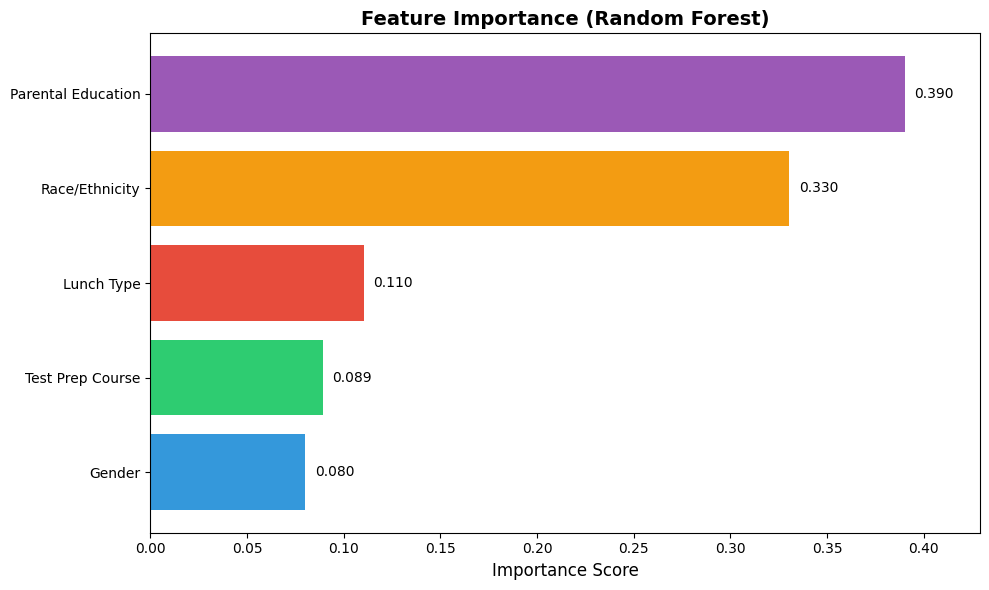

In [41]:
# Create and save Feature Importance chart for presentation
import matplotlib.pyplot as plt

# Get feature importance from the trained Random Forest model
feature_names = ['Gender', 'Race/Ethnicity', 'Parental Education', 'Lunch Type', 'Test Prep Course']
importances = model.feature_importances_

# Sort by importance
sorted_idx = importances.argsort()
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(sorted_features, sorted_importances, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])

# Styling
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(sorted_importances) * 1.1)

# Add value labels
for bar, val in zip(bars, sorted_importances):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=10)

plt.tight_layout()

# Save the figure
plt.savefig('../feature_importance.png', dpi=150, bbox_inches='tight', facecolor='white')
print("Feature importance chart saved to ../feature_importance.png")
plt.show()

## Phase 7: Export Model for Streamlit

In [39]:
# Export sklearn model for Streamlit (demographics only - no test scores)
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import os

# Convert to pandas
pdf = data.toPandas()

# Categorical features only (predict BEFORE knowing test scores)
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Encode categorical features
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    pdf[col + '_enc'] = le.fit_transform(pdf[col])
    label_encoders[col] = le

# Prepare X (demographics only) and y (performance level)
X = pdf[[col + '_enc' for col in cat_cols]]
y = pdf['PerformanceLevel']

# Encode target
target_le = LabelEncoder()
y_enc = target_le.fit_transform(y)

# Train sklearn RandomForest
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X, y_enc)

# Calculate accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y_enc, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

# Save model
os.makedirs('../models', exist_ok=True)
joblib.dump({
    'model': model,
    'label_encoders': label_encoders,
    'target_encoder': target_le,
    'feature_cols': cat_cols
}, '../models/student_model.pkl')

print("Model saved to ../models/student_model.pkl")

Cross-validation accuracy: 0.489 (+/- 0.044)
Model saved to ../models/student_model.pkl
